In [ ]:
import tensorflow as tf

Creating tensor


In [ ]:
String = tf.Variable('Saif',tf.string)
number = tf.Variable(16,tf.int16)
float = tf.Variable(2.22,tf.float64)

Rank/ Degree of tensors - it means the number of dimensions in a tensor. all the above ex are tensors of rank 0 or known as scalars

In [ ]:
rank1_tensor = tf.Variable(['Test'],tf.string)
rank2_tensor = tf.Variable([['test'],['ok']],tf.string)

In [ ]:
tf.rank(rank1_tensor)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [ ]:
tf.rank(number)

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [ ]:
tf.rank(rank2_tensor)

<tf.Tensor: shape=(), dtype=int32, numpy=2>

Shape of Tensors - amount of elements that exist in each dimensions

In [ ]:
rank2_tensor.shape

TensorShape([2, 1])

Changing shape 

In [ ]:
tensor1 = tf.ones([1,2,3]) ## creates a shape (1,2,3) with all ones in it
print(tensor1) ## it says we have 1 list with 2 list inside it and 3 elements in both those lists
tensor2 = tf.reshape(tensor1, [2,3,1]) ## reshape it to (2,3,1)
print(tensor2) # we have 2 lists and 3 lists inside them with 1 element inside each

tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]]], shape=(1, 2, 3), dtype=float32)
tf.Tensor(
[[[1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]]], shape=(2, 3, 1), dtype=float32)


Evaluating tensors - There will be sometimes when we need to evaluate a tensor or in other words get its value. since tensors represent a partially complete computation we will sometime need to run whats called a session to evaluate the tensor.


In [ ]:
t = tf.zeros([2,2,2,2])
t

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float32, numpy=
array([[[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]]], dtype=float32)>

In [ ]:
tf.reshape(t,[16,1])

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

TensorFlow Core Learning Algorithms

Linear Regression

In [ ]:
!pip install -q sklearn

In [ ]:
from __future__ import absolute_import,division,print_function,unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf


Data 


In [ ]:
dftrain = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
dfeval = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")
dftrain.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [ ]:
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [ ]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [ ]:
print(dftrain.loc[0],y_train.loc[0])

sex                          male
age                            22
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object 0


In [ ]:
categorical_columns = ['sex','n_siblings_spouses','parch','class','deck','embark_town','alone']

numeric_columns = ['age','fare']

feature_columns = []

for column in categorical_columns:
  vocabulary = dfeval[column].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(column,vocabulary))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(0, 3, 2, 1, 5, 4, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 4, 6, 3, 5), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'E', 'C', 'D', 'F', 'B', 'A'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Queenstown', 'Cherbourg', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('y', 'n'), dtype=tf.string, defau

In [ ]:
dftrain['sex'].unique()

array(['male', 'female'], dtype=object)

Training the data - loading in batches as if we have large dataset we can do it effeciently.
epochs is number of times we run the model on our dataset

If our epoch is 10 our model will see the dataset 10 times.
Since we need to feed our data in batches and multiple times we need to create something called an input fn. the input fn defines how our dataset will be converted into batches at each epoch.

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

Creating the model

In [ ]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdudfgxkc', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

print(result['accuracy'])

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpdudfgxkc/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:global_step/sec: 279.017
INFO:tensorflow:loss = 0.3899979, step = 100 (0.362 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200...
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmpdudfgxkc/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200...
INFO:tensorflow:Loss for final step: 0.55809885.
INFO:tensorflow:Calling model_fn.
I

In [ ]:
result = list(linear_est.predict(eval_input_fn))
print(dfeval.loc[1])
print(y_eval.loc[1])
print(result[1]['probabilities']) ## person did not survive but only we got 54$ chance of it not surviving 

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdudfgxkc/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
sex                          male
age                            54
n_siblings_spouses              0
parch                           0
fare                      51.8625
class                       First
deck                            E
embark_town           Southampton
alone                           y
Name: 1, dtype: object
0
[0.5412999  0.45870003]


Hidden MArkov models - it is a finite set of states , each of which is associated with a generally multidimensional probability distribution transitions among the states are governed by a set of probabilities called transition probabilities

hidden markov model works with probabilities to  predict future events or states. 



Data 

**States** - In each markov model we have a finite set of states. these states could be something like warm or cold or hifh or low.
these states are hidden within the model and we do not directly observe them

**Observation** - Each state has a particular outcome or observation associated with it based on a probability distribution. an example is the following: on hot day there is 80% chance of being happy and 20% of being sad

**Transition** - Each state will have a probability of transitioning to a different state. e.g a cold day has 30% chance of being followed by a hot day and 30% chance of being followed by a codl day/

To create a hidden markov model we need.
1) States
2) Observation distribution
3) Transition Distribution



we build a simple weather system and try to preict the temperature on each day given the following information.

1) cold days are encoded by a - and hot days are encoded by a 1
2) first day in our sequence has an 80% chance of being cold.
3) a cold day has 30% chance of being followed by a hot day
4) a hot day has 20% chance of being followed by a cold day
5) on each day the temperature is normally distributed with mean and standard deviation 0 and 5 on a cold day and 15 and 10 for hot day



In [ ]:
import tensorflow_probability as tfp
import tensorflow as tf

In [ ]:
tfd = tfp.distributions
initial_distribution = tfd.Categorical(probs=[0.8,0.2]) # 2nd point
transition_distribution = tfd.Categorical(probs=[[0.7,0.3],[0.2,0.8]]) # referes to point 4

observation_distribution = tfd.Normal(loc=[0.,15.],scale=[5.,10.]) # refers to point 5

we have created distribution variables to model our system and its time to create the hidden markov model

In [ ]:
model = tfd.HiddenMarkovModel(initial_distribution=initial_distribution,transition_distribution=transition_distribution,observation_distribution=observation_distribution,num_steps=7) # n
#num_steps is the no of days for which we need to predict these 

In [ ]:
mean = model.mean()

# due to the way tensorFlow works on a lower level we need to evaluate the part of the graph from within a session to see the value of this tensor
with tf.compat.v1.Session() as sess:
  print(mean.numpy())   # We are starting with a cold day

[2.9999998 5.9999995 7.4999995 8.25      8.625001  8.812501  8.90625  ]


Creating Neural Network

In [ ]:
from tensorflow import keras

Dataset used is MNIST fashion dataset. this is a dataset that  has 60,000 training images and 10,000 images for validation

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist # load dataset

(train_images , train_labels), (test_images,test_labels) = fashion_mnist.load_data() # split into testing and training



4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
train_images.shape  # 28x28 

(60000, 28, 28)

In [ ]:
train_images[0,23,23] # looking at one pixel, we have grayscale image as it is btw 0 and 255

194

In [ ]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [ ]:
train_labels[:10]  # we have 10 different classes which are  given in the next cell

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

In [ ]:
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']


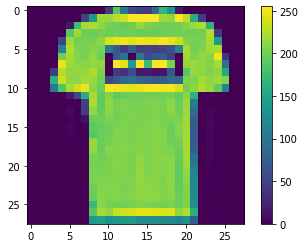

In [ ]:
plt.figure()
plt.imshow(train_images[1])
plt.colorbar()
plt.grid(False)
plt.show()

Data Preprocessing

Scaling our grayscale image(0,255) to be between (0,1). we can do this by dividing each value by 255. 

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Building the model

In [ ]:
model = keras.Sequential()

In [ ]:
model.add(keras.layers.Flatten(input_shape = (28,28))) # input layer, flattens it into a single column vector

In [ ]:
model.add(keras.layers.Dense(units=128,activation='relu')) # hidden layer

In [ ]:
model.add(keras.layers.Dense(units=10,activation='softmax'))

Compiling the model

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(train_images,train_labels,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2332 - accuracy: 0.9124
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2257 - accuracy: 0.9150
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2185 - accuracy: 0.9173
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2129 - accuracy: 0.9191
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2055 - accuracy: 0.9230


Evaluating the model

In [ ]:
test_loss, test_acc = model.evaluate(test_images,test_labels,verbose=1)

print('Test accuracy', test_acc)

313/313 [==============================] - 0s 1ms/step - loss: 0.3361 - accuracy: 0.8872
Test accuracy 0.8871999979019165


In [ ]:
predictions = model.predict(test_images)

In [ ]:
print(class_names[np.argmax(predictions[0])])

Ankle boot


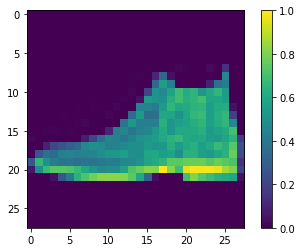

In [ ]:
plt.figure()
plt.imshow(test_images[0])
plt.colorbar()
plt.grid(False)
plt.show()   # yes its an ankle boot as predicted above 

Deep Computer vision

Image Data 
it can be of 3 dimensions - image height, width and color channels(RGB).

Convlution nn vs dense nn:-
the dense layers detect patterns globally whereas the cnn detects pattern locally. what we mean by that is let say we have an image of a cat and we have features let say ears paws eyes . if we rotate the image the dense layer will  say its not a cat , it will consider it as new but for cnn it will not .





CIFR image dataset - it contains 60,000 i32x32 color images with 6000 images of each class


In [ ]:
from tensorflow.keras import datasets, layers, models
import tensorflow as tf


In [ ]:
(train_images,train_labels),(test_images,test_labels) = datasets.cifar10.load_data()

In [ ]:
#Normalizing pixel values
train_images,test_images = train_images/255.0, test_images/255.0

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

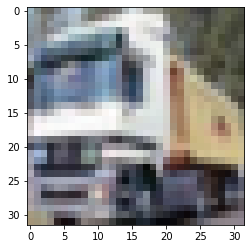

In [ ]:
#Lets look at 1 image
import matplotlib.pyplot as plt


IMG_index = 1
plt.imshow(train_images[IMG_index])
plt.show()

CNN architecture

Layer 1 
The input shape of our data is 32,32,3 and we will process 32 filters of size 3x3 over our input data. we will also apply the activation fn relu to the output of each convolution operation

Layer 2 
Max pooling using 2x2 samples

Other layers
The next set of layers do very similar things but take as input the feature map from the previous layer. they also increase the freq of filters from 32 to 64. we can do this as our data shrinks in special dimensions as it is passed through the layers . meaning we can afford to add more depth


In [ ]:
cnn = tf.keras.Sequential()

In [ ]:
cnn.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(32,32,3)))

In [ ]:
cnn.add(layers.MaxPool2D((2,2)))

In [ ]:
cnn.add(layers.Conv2D(32,(3,3),activation='relu'))

In [ ]:
cnn.add(layers.MaxPool2D((2,2)))

In [ ]:
cnn.add(layers.Conv2D(32,(3,3),activation='relu'))

In [ ]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 32)          9248      
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
_________________________________________________________________


Adding dense layers
So far we have just completed the convolutional base . now we need to take the extracted features and add a way to classify them

In [ ]:
cnn.add(layers.Flatten())

In [ ]:
cnn.add(layers.Dense(32,activation='relu'))

In [ ]:
cnn.add(layers.Dense(10,activation='softmax')) # 10 things to classify

In [ ]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 32)          9248      
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)               

Training
Now we will train and complete the model using the recommended hyper parameters from tensorflow.

In [ ]:
cnn.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])